<a href="https://colab.research.google.com/github/park-geun-hyeong/Kaggle_project/blob/main/Computer-Vision/Kaggle_Wheat_Detection/Pytorch_FasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Library Import

In [ ]:
! pip install albumentations --upgrade
! pip install torchvision --upgrade

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import os
from tqdm import tqdm
import time 
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
import re

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader,Dataset
from torch.utils.data.sampler import SequentialSampler

path = '/content/drive/MyDrive/Kaggle/Computer_Vision/Kaggle_wheat_detection/'

In [12]:
print(A.__version__)
print(torchvision.__version__)

0.5.2
0.9.0+cu101


## Train Data Preprocessing

In [13]:
train = pd.read_csv(path+'train.csv')
print(train.shape)
train.head()

(147793, 5)


,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [14]:
train['x'] = -1
train['y'] = -1 
train['w'] = -1
train['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x)) ## ?-앞의 문자가 존재할수도 아닐수도, *-앞의 문자가 무한대로 존재할수도 아닐수도
    if len(r) == 0:
        r = [-1,-1,-1,-1]

    return r

train[['x','y','w','h']] = np.stack(train['bbox'].apply(lambda x :expand_bbox(x)))
train['x'] = train['x'].astype(np.float)
train['y'] = train['y'].astype(np.float)
train['w'] = train['w'].astype(np.float)
train['h'] = train['h'].astype(np.float) 


In [15]:
del train['bbox']

In [85]:
train.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


In [16]:
image_ids = train['image_id'].unique()
val_ids = image_ids[-655:]
train_ids = image_ids[:-655]

In [17]:
val_df = train[train['image_id'].isin(val_ids)]
train_df = train[train['image_id'].isin(train_ids)]

In [18]:
print("train_df_shape: {}".format(train_df.shape))
print("val_df_shape: {}".format(val_df.shape))

train_df_shape: (123025, 8)
val_df_shape: (24768, 8)


In [19]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [20]:
def get_train_transform(): ## Train,Val data Augmentation
    return A.Compose([A.Flip(0.5), ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    
def get_valid_transform():
    return A.Compose([ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

## Load Model(fasterRCNN-backbone:resnet50)

In [21]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [22]:
num_classes = 2 #wheat, background

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [23]:
class Averager:
    def __init__(self):
        self.curent_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.curent_total += 1
        self.iterations += 1


    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.curent_total / self.iterations

    def reset(self):
        self.curent_total = 0.0
        self.iterations = 0.0

## Create Train, Val Data 

In [24]:
train_img_path = '/content/drive/MyDrive/Kaggle/Computer_Vision/Kaggle_wheat_detection/train'

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df,train_img_path,get_train_transform())
val_dataset = WheatDataset(val_df,train_img_path,get_valid_transform())

indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size = 8,
    shuffle= False,
    num_workers = 4,
    collate_fn = collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [25]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') ## cuda

In [26]:
images, targets, image_ids = next(iter(train_data_loader))

images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [27]:
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()# channel axis=2로 이동

In [ ]:
plt.figure(figsize=(8,8))

for box in boxes:
    cv2.rectangle(sample, (box[0],box[1]), (box[2],box[3]), color=(255,0,0), thickness=2)

plt.imshow(sample)


In [29]:
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay = 0.0005)

lr_scheduler = None

num_epochs=2

In [30]:
torch.cuda.empty_cache()
import gc
gc.collect()

100

## Train

In [ ]:
loss_hist = Averager()

itr=1

for epoch in range(num_epochs):
    loss_hist.reset()

    for images, targets, image_ids in train_data_loader:

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images,targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

## Evaluate Through Validation Data

In [33]:
images, targets, image_ids = next(iter(val_data_loader))

In [34]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [36]:
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()

In [37]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


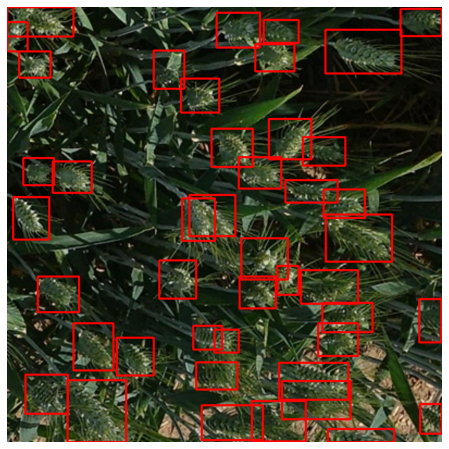

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

## Save Model

In [40]:
os.chdir('/content/drive/MyDrive/Kaggle/Computer_Vision/Kaggle_wheat_detection') 
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

In [41]:
submission = pd.read_csv(path+'sample_submission.csv')
submission

,image_id,PredictionString
0,aac893a91,1.0 0 0 50 50
1,51f1be19e,1.0 0 0 50 50
2,f5a1f0358,1.0 0 0 50 50
3,796707dd7,1.0 0 0 50 50
4,51b3e36ab,1.0 0 0 50 50
5,348a992bb,1.0 0 0 50 50
6,cc3532ff6,1.0 0 0 50 50
7,2fd875eaa,1.0 0 0 50 50
8,cb8d261a3,1.0 0 0 50 50
9,53f253011,1.0 0 0 50 50


In [42]:
test_img_path = path+'test'

os.listdir(test_img_path)


['51b3e36ab.jpg',
 '2fd875eaa.jpg',
 '348a992bb.jpg',
 'cb8d261a3.jpg',
 'aac893a91.jpg',
 '796707dd7.jpg',
 '53f253011.jpg',
 'f5a1f0358.jpg',
 'cc3532ff6.jpg',
 '51f1be19e.jpg']

In [49]:
weight_path = '/content/drive/MyDrive/Kaggle/Computer_Vision/Kaggle_wheat_detection/fasterrcnn_resnet50_fpn.pth'

In [44]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]



In [45]:
def get_test_transform():
    return A.Compose([ToTensorV2(p=1.0)])

In [46]:
model =  torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)


In [47]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [50]:
num_classes = 2

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load(weight_path))
model.eval()

x=model.to(device)


In [51]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = WheatTestDataset(submission, test_img_path, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)


In [52]:
torch.cuda.empty_cache()
gc.collect()

427

In [58]:
def format_submission_string(score, box): ## submission 형태로 변환
    pred_string=[]

    for j in zip(score, box):
        pred_string.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0],j[1][1],j[1][2],j[1][3]))


    return " ".join(pred_string)    

## Predict Test Data

In [59]:
detection_th = 0.5
results=[]

for images, image_ids in test_data_loader:
    images = list(image.to(device) for image in images)
    output = model(images)

    for idx, image in enumerate(images):
        boxes = output[idx]['boxes'].data.cpu().numpy()
        scores = output[idx]['scores'].data.cpu().numpy()

        boxes = boxes[scores >= detection_th].astype(np.int32)
        scores = scores[scores >= detection_th].astype(np.float)
        image_id = image_ids[idx]

        boxes[:,2] = boxes[:,2] - boxes[:,0]
        boxes[:,3] = boxes[:,3] - boxes[:,1]

        result = {'image_id':image_id, 'PredictionString':format_submission_string(scores, boxes)}

        results.append(result)



In [60]:
submission = pd.DataFrame(results, columns=['image_id','PredictionString'])

In [88]:
submission

,image_id,PredictionString
0,aac893a91,0.9868 72 0 97 164 0.9786 616 913 79 109 0.971...
1,51f1be19e,0.9628 273 472 147 127 0.9446 759 877 162 115 ...
2,f5a1f0358,0.9626 133 748 175 140 0.9577 881 633 94 159 0...
3,796707dd7,0.9389 893 331 110 95 0.9340 0 450 71 74 0.931...
4,51b3e36ab,0.9810 528 25 266 142 0.9777 862 290 162 148 0...
5,348a992bb,0.9876 0 315 123 106 0.9793 0 465 141 114 0.97...
6,cc3532ff6,0.9792 0 408 154 112 0.9742 377 0 81 109 0.970...
7,2fd875eaa,0.9796 100 584 148 90 0.9772 0 910 111 82 0.97...
8,cb8d261a3,0.9398 20 861 84 151 0.9250 750 711 89 89 0.92...
9,53f253011,0.9740 469 451 159 216 0.9699 929 201 95 143 0...


## Visualization Test Image(predicted_bbox)

In [82]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = output[1]['boxes'].data.cpu().numpy()
scores = output[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_th].astype(np.int32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


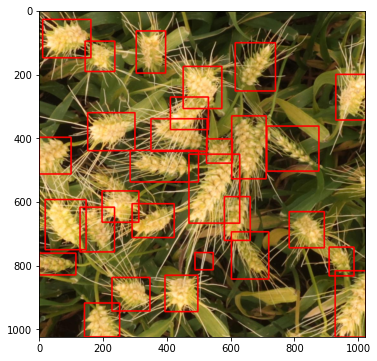

In [89]:
plt.figure(figsize=(6,6))

for box in boxes:
    cv2.rectangle(sample, (box[0],box[1]) , (box[2],box[3]), color=(255,0,0), thickness=3)

plt.imshow(sample)
plt.show()

In [91]:
os.chdir('/content')
submission.to_csv('wheat_detection_submission.csv',index=False)